# Coordinate Exchange for D-Optimal Mixture Designs
## Summary
This notebook contains an implementation of the coordinate exchange optimization algorithm for mixture design experiments with no process variables. Under these constraints, the design space is a regular $(K-1)$-simplex $\Delta^{K-1}$, where $K$ is the number of experimental factors. The optimal design is found with respect to the $D$-optimality criterion.

## Packages

In [6]:
using Combinatorics
using LinearAlgebra
using Optim
using ThreadsX
using Base: hash
using BenchmarkTools
using HDF5

include("../model_builder/model_builder.jl")
using .ModelBuilder

include("../model_builder/design_initializer.jl")
using .DesignInitializer

## Coordinate Exchange Implementation
The key difference in the mixture coordinate exchange implementation lies in the optimization step. We cannot vary each coordinate in a given design point independently of the others because doing so could yield a design point outside the feasible region. Thus we employ a trick called the Cox-effect direction, which allows us to simplify the optimization significantly while respecting the mixture constraint. 

Let $M$ be a design matrix on $N$ design points and $K$ factors, and consider the $n$-th design point $M_{n:}$. In the coordinate exchange algorithm, we iterate over each factor $k$ of $M_{n:}$ in order to optimize the value of $M_{n,k}$ with respect to the objective criterion, which is a function of the model matrix corresponding to $M$. We need to be able to optimize the value of $M_{n,k}$ while respecting the closure property on $M_{n:}$. Here is where the Cox-effect trick comes in. Rather than optimize $M_{n,k}$ over the entire design space, we instead consider only solutions along the line connecting $M_{n,k}$ to the $k$-th vertex of the $K-1$-simplex; in other words, we move the design point towards $(0,0,\ldots, 1_k, \ldots, 0, 0)$, which represents the most extreme value of that factor. 

The direction vector between $M_{n,k}$ and the $k$-th vertex of the simplex $e_k$ is $d = e_k - M_{n:}$. We can then consider design points of the form 

$$
    M_{n:}^*=M_{n:}+\lambda d
$$

which lie on the line connecting $e_k$ and $M_{n:}$ for $\lambda\in[0,1]$. Simplices are convex by definition, meaning convex combinations of vectors in the simplex will also be contained in the simplex. Therefore 

$$
    M_{n:}^*=M_{n:}+\lambda d =\lambda e_k +(1-\lambda)M_{n:}\in\Delta^{K-1}
$$

In other words, any candidate design point $M_{n:}^*$ of this form is guaranteed to lie in the feasible region. Moreover, we need only optimize the objective function now as a function of $\lambda$.

### Optimizers
Two optimizers are implemented here. The first uses the Julia `Optim` package to find the minimum objective score and minimizing value of $\lambda$. The second takes a set of evenly spaced samples along the line (including the endpoints) and computes the objective score for each, returning the minimum score and minimizing $\lambda$ value.

### CEXCH Implementation for Mixture Designs

In [2]:
function cexch_optimize(X::Matrix{Float64}, obj_crit::Function, opt_func::Function; max_iters=1000, tol=1e-6)
    N, K = size(X)

    # Generate simplex coordinates using identity matrix
    # The kth column corresponds with the simplex vertex for the kth factor
    simplex_coords = I(K)

    # Initialize objective value
    obj_crit_val = obj_crit(X)
    score_opt = obj_crit_val

    # Iterate until no improvement is made
    for iter in 1:max_iters
        improvement = false

        # Iterate over the coordinates of the matrix
        for row in 1:N
            for col in 1:K
                # Get the current simplex vertex
                v = simplex_coords[:, col]

                # Get the direction vector
                d = v - X[row, :]

                # Optimize the objective function along the line from x to v
                (score_opt, t_opt) = opt_func(X, row, d, obj_crit)

                # Update the design matrix and objective value if improvement is found
                if score_opt < obj_crit_val
                    X[row, :] += t_opt * d
                    obj_crit_val = score_opt
                    improvement = true
                end
            end
        end

        # Check for convergence
        if !improvement
            break
        end
    end
    return X
end

cexch_optimize (generic function with 1 method)

In [3]:
function exchange(X, row, x)
    Xt = copy(X)
    Xt[row, :] = x
    Xt
end

function remove_small_terms(X; tol=1e-6)
    indices = findall(x -> abs(x) < tol, X)
    X[indices] .= 0
    return X
end

function cexch_optimize(X::Matrix{Float64}, obj_crit::Function; max_iters=1000, num_samples=100)
    N, K = size(X)

    # Generate simplex coordinates using identity matrix
    # The kth column corresponds with the simplex vertex for the kth factor
    simplex_coords = I(K)

    # Sample points along line
    sample_points = range(0.0, 1.0, length=num_samples)

    # Initialize objective value
    best_score = obj_crit(X)

    # Pre-allocate memory for designs
    new_designs = zeros(num_samples, N, K)

    # Initialize metadata
    cexch_meta = zeros(4)
    cexch_meta[2] = max_iters
    cexch_meta[3] = num_samples

    # Iterate until no improvement is made
    for iter in 1:max_iters
        improvement = false

        for coord in CartesianIndices(X)
            row, col = coord[1], coord[2]
            # Get the current simplex vertex
            v = simplex_coords[:, col]

            # Get the direction vector
            d = v - X[row, :]
            
            # Generate candidate designs
            for (i, t) in enumerate(sample_points)
                new_designs[i, :, :] = exchange(X, row, X[row, :] + t * d)
            end

            # Compute scores
            scores = obj_crit(new_designs)
            score_opt, i_opt = findmin(ModelBuilder.squeeze(scores))

            # Update the design matrix and objective value if improvement is found
            if score_opt < best_score
                best_score = score_opt
                X = new_designs[i_opt, :, :]
                improvement = true
            end
        end

        cexch_meta[1] = iter
        if !improvement
            break
        end
    end

    cexch_meta[4] = best_score
    return X, cexch_meta
end

# Simple coordinate exchange algorithm implementation for mixture designs
function cexch!(X::Array{Float64, 3}, model_builder::Function, obj_crit::Function; max_iters=1000, num_samples=1000)
    n = size(X, 1) # number of design matrices
    meta = zeros(n, 4) # metadata for each design matrix

    # Parallelize over initializations
    Threads.@threads for i in 1:n
        X_new, m = cexch_optimize(X[i, :, :], obj_crit ∘ model_builder, max_iters=max_iters, num_samples=1000)
        X[i, :, :] = X_new
        meta[i, :] = m
    end

    return remove_small_terms(X), meta
end

cexch! (generic function with 1 method)

In [4]:
filename = "cexch_designs.h5"
n_samples = 10000

10000

In [7]:
model_builder = ModelBuilder.scheffe(1)
init = DesignInitializer.initializer(6, 3, model_builder, type="mixture")
designs = init(n_samples)
opt_designs, meta = cexch!(designs, model_builder, d_criterion, max_iters=100, num_samples=500)
h5write(filename, "design_scheffe_1_6_3", opt_designs)
h5write(filename, "meta_scheffe_1_6_3", meta)

UndefVarError: UndefVarError: `d_criterion` not defined

In [ ]:
model_builder = ModelBuilder.scheffe(2)
init = DesignInitializer.initializer(6, 3, model_builder, type="mixture")
designs = init(n_samples)
opt_designs, meta = cexch!(designs, model_builder, d_criterion, max_iters=100, num_samples=500)
h5write(filename, "design_scheffe_2_6_3", opt_designs)
h5write(filename, "meta_scheffe_2_6_3", meta)

In [11]:
model_builder = ModelBuilder.scheffe(3)
init = DesignInitializer.initializer(7, 3, model_builder, type="mixture")
designs = init(n_samples)
opt_designs, meta = cexch!(designs, model_builder, d_criterion, max_iters=100, num_samples=500)
h5write(filename, "design_scheffe_3_7_3", opt_designs)
h5write(filename, "meta_scheffe_3_7_3", meta)

In [42]:
model_builder = ModelBuilder.full_cubic
init = DesignInitializer.initializer(6, 3, model_builder, type="mixture")
designs = init(n_samples)
opt_designs, meta = cexch!(designs, model_builder, d_criterion, max_iters=100, num_samples=500)
h5write(filename, "design_full_cubic_6_3", opt_designs)
h5write(filename, "meta_full_cubic_6_3", meta)

## Constrained Optimization

In [16]:
# A is a matrix LxK, where L is the number of constraints and K the number of factors
# b is a vector of length L representing the right-hand side of the inequality constraints
# We want to find the maximum value of lambda such that A * (X + lambda * d) >= b
function compute_lambda_constraint(X, row, k, A, b)
    mat = A * X[row, :]'
    t_cands = (b' - mat) ./ (A[:, k] - mat)
    minimum(t_cands[t_cands .>= 0]..., 1)
end

compute_lambda_constraint (generic function with 1 method)

In [12]:
function mc_mixture_rejection_sampling(A, b, initializer; n_samples=1000)
    L, K = size(A)
    samples = zeros(n_samples, K)
    n = 0
    while n_samples - n > K-1
        x = initializer(n_samples - n)
        valid_check = A * x' .>= b
        valids = ModelBuilder.squeeze(all(valid_check, dims=1))
        samples[(n+1):n+sum(valids), :] = x[valids, :]
        n += sum(valids)        
    end

    return samples
end

function reshape_init(initializer)
    function f(n_samples)
        designs = initializer(n_samples)
        reshape(designs, n_samples * size(designs, 2), size(designs, 3))
    end
end

reshape_init (generic function with 1 method)

In [14]:
A = ModelBuilder.expand([1 1 1], n=2)
b - ModelBuilder.expand([1], n=2)'
n_samples = 1000000

filename = "simplex_unconstrained_samples.h5"

Ks = [2,3,4,5]
Ns = [6,7,8,9,10,11,12]
models = zip([ModelBuilder.scheffe(1), ModelBuilder.scheffe(2), ModelBuilder.scheffe(3), ModelBuilder.full_cubic], ["scheffe_1", "scheffe_2", "scheffe_3", "full_cubic"])

cart_prod = product(Ns, Ks, models)

for (N, K, model) in cart_prod
    (model_builder, name) = model
    init = DesignInitializer.initializer(N, K, model_builder, type="mixture")
    init = reshape_init(init)
    designs = mc_mixture_rejection_sampling(A, b, init, n_samples=N*n_samples)
    designs = reshape(designs, n_samples, N, K)
    models = model_builder(designs)
    scores = d_criterion(models)
    h5write(filename, "scores_$(name)_$(N)_$(K)", scores)
    h5write(filename, "designs_$(name)_$(N)_$(K)", designs)
    h5write(filename, "models_$(name)_$(N)_$(K)", name)
end

UndefVarError: UndefVarError: `b` not defined

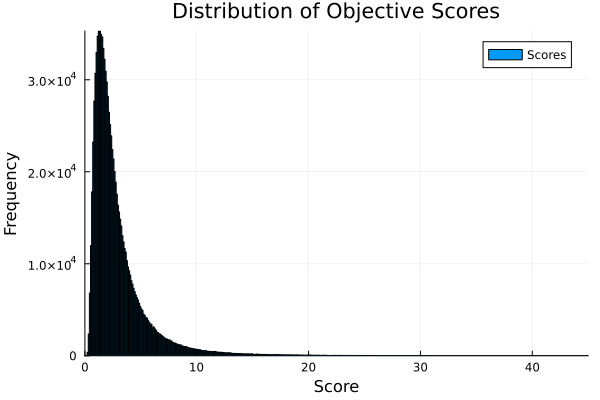

In [522]:
# Get initializer for matrices
# Base initializer returns function of n that returns n x 1 x K array
# Reshape init will return function of n that returns n x K array
init = DesignInitializer.initializer(1, K, model_builder, type="mixture")
init = reshape_init(init)

# Use MC sampling to get samples in the feasible region
valid_samples = mc_mixture_rejection_sampling(A, b, init, n_samples=N*n_samples)

# Reshape the samples to get (n_samples / N) x N x K array
designs = reshape(valid_samples, n_samples, N, K)

# Compute scores for each design
models = model_builder(designs)
scores = ModelBuilder.squeeze(d_criterion(models))

## D-Optimal Design

$D$-optimality is a criterion that seeks to maximize the determinant of the information matrix, which is a measure of the volume of the confidence ellipsoid for the parameter estimates. Here we minimize the inverse of the determinant of the Fisher information of the model matrix corresponding with the design. 

In [2]:
function d_criterion(X::Array{Float64, 2})
    score = abs(det(X' * X))
    if score == 0
        return Inf
    else
        return 1 / score
    end
end

function d_criterion(X::Array{Float64, 3})
    mapslices(d_criterion, X, dims=[2,3])
end

d_criterion (generic function with 2 methods)

## Examples

### First-Order Scheffe

In [11]:
# Get the model builder and design initializer for N=9, K=3
model_builder = ModelBuilder.scheffe(1)
init = DesignInitializer.initializer(9, 3, model_builder, type="mixture")

# Randomly initialize 10 design matrices in the simplex
designs = init(10)

# Optimize the designs using the D-criterion
optimal_designs = cexch!(designs, model_builder, d_criterion, jl_optimizer, max_iters=10)

# Print the first optimal design
optimal_designs[1, :, :]

9×3 Matrix{Float64}:
 0.0  1.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0
 0.0  0.0  1.0
 0.0  1.0  0.0
 1.0  0.0  0.0

### Second-Order Scheffe

In [99]:
# Get the model builder and design initializer for N=6, K=3
model_builder = ModelBuilder.scheffe(2)
init = DesignInitializer.initializer(6, 3, model_builder, type="mixture")

# Randomly initialize 10 design matrices in the simplex
designs = init(1000)

# Optimize the designs using the D-criterion
optimal_designs = cexch!(designs, model_builder, d_criterion, jl_optimizer, max_iters=100)

# Print the first optimal design
optimal_designs[1, :, :]

### Special-Cubic Model


In [114]:
# Get the model builder and design initializer for N=7, K=3
model_builder = ModelBuilder.scheffe(3)
init = DesignInitializer.initializer(7, 3, model_builder, type="mixture")

# Randomly initialize 10 design matrices in the simplex
designs = init(10)

# Optimize the designs using the D-criterion
optimal_designs = cexch!(designs, model_builder, d_criterion, m_optimizer, max_iters=100)

# Print the first optimal design
optimal_designs[1, :, :]

7×3 Matrix{Float64}:
 0.499439     0.500561     0.0
 0.0          0.0          1.0
 1.0          0.0          0.0
 0.0          1.0          0.0
 0.497612     0.000678815  0.501709
 0.000832756  0.497039     0.502129
 0.333404     0.334793     0.331803

## Build Distribution of Optimized Designs

In [136]:
# Hash a single design matrix
function hash_design(X)
    return hash(vec(X))
end

# Create a vector of hatches length n, the number of designs in X
function hash_designs(X)
    vec(mapslices(hash_design, X, dims=[2,3]))
end

function canonicalize(X; digits=2)
    sort(round.(X, digits=digits), dims=[2,3])
end

# Get frequencies of unique designs
# Returns a dictionary with the design hash as the key and the frequency as the value
function get_frequencies(X)
    unique_designs = (hash_designs ∘ canonicalize)(X)
    dict = Dict()
    
    for i in 1:size(X, 1)
        design = unique_designs[i]
        if haskey(dict, design)
            dict[design] += 1
        else
            dict[design] = 1
        end
    end

    return (unique_designs, dict)
end

# Function to get the first design matching the hash value from the design tensor
function get_design(X, hash_value, design_hashes)
    for (i, h) in enumerate(design_hashes)
        if h == hash_value
            return X[i, :, :]
        end
    end

    return nothing
end

get_design (generic function with 1 method)

In [137]:
unique_designs, dict = get_frequencies(optimal_designs)
dict

Dict{Any, Any} with 4 entries:
  0xe95a42b58485e433 => 6
  0xee897dfa1507e923 => 2
  0x597d3d1034462763 => 1
  0x9edaeff6fdc5b5e3 => 1

In [138]:
cat([get_design(optimal_designs, k, unique_designs) for (k, v) in dict]..., dims=3)[:, :, 3]

7×3 Matrix{Float64}:
 0.0         0.0        1.0
 0.0         1.0        0.0
 1.0         0.0        0.0
 0.497712    0.501633   0.000654365
 0.496602    0.0006509  0.502747
 0.334555    0.330097   0.335347
 0.00071589  0.497556   0.501728

## Future Work
There are many potential avenues of exploration branching from this project. Among these are :
- Adding constraints, such as bounded factors, ratio constraints, and mixture-amount experiments
- Optimizing designs for more complex models
- Introducing additional optimality criteria, such as I-optimality
- Mixture-process experiments

## Testing
Some designs are very simple to check for optimality. For a first-order Scheffe model on $K$ factors and $N$ design points, the optimal design consists of one or more replicates of the vertices of $\Delta^{K-1}$. If $K|N$, then the optimal design will include exactly $\frac{K}{N}$ copies of each vertex.

In [73]:
function test_scheffe_order_one_design(N, K; num_designs=10, max_iters=10, opt_func=m_optimizer, tol=1e-6)
    model_builder = ModelBuilder.scheffe(1)
    init = DesignInitializer.initializer(N, K, model_builder, type="mixture")
    designs = init(num_designs)
    optimal_designs = cexch!(designs, model_builder, d_criterion, opt_func, max_iters=max_iters)
    
    if N % K == 0
        # Check that the sum of each column is N/K
        for i in 1:num_designs
            for j in 1:K
                @assert abs((sum(optimal_designs[i, :, j]) - N/K)) < tol
            end
        end
    else 
        # Check that each row sums to 1 and that the max value in the row is 1 within the tolerance
        for i in 1:num_designs
            for j in 1:N
                @assert abs((sum(optimal_designs[i, j, :]) - 1)) < tol
                @assert abs(max(optimal_designs[i, j, :]...) - 1) < tol
            end
        end
    end
end

test_scheffe_order_one_design (generic function with 1 method)

In [74]:
test_scheffe_order_one_design(9, 3)

In [75]:
test_scheffe_order_one_design(10, 4)

### Unit Testing

In [76]:
using Test

# Define test cases
divisible_cases = [(6, 3), (8, 4), (10, 5)] # K divides N
non_divisible_cases = [(7, 3), (9, 4), (10, 3)] # K does not divide N

num_designs = 10
max_iters = 10
tol = 1e-6

@testset "Scheffe Order One Design Tests" begin
    @testset "K divides N" for (N, K) in divisible_cases
        model_builder = ModelBuilder.scheffe(1)
        init = DesignInitializer.initializer(N, K, model_builder, type="mixture")
        designs = init(num_designs)
        optimal_designs = cexch!(designs, model_builder, d_criterion, m_optimizer, max_iters=max_iters)

        @testset "Optimal design for N = $N, K = $K" begin
            for i in 1:num_designs
                for j in 1:K
                    @test abs((sum(optimal_designs[i, :, j]) - N/K)) < tol
                end
            end
        end
    end

    @testset "K does not divide N" for (N, K) in non_divisible_cases
        model_builder = ModelBuilder.scheffe(1)
        init = DesignInitializer.initializer(N, K, model_builder, type="mixture")
        designs = init(num_designs)
        optimal_designs = cexch!(designs, model_builder, d_criterion, m_optimizer, max_iters=max_iters)

        @testset "Optimal design for N = $N, K = $K" begin
            for i in 1:num_designs
                for j in 1:N
                    @test abs((sum(optimal_designs[i, j, :]) - 1)) < tol
                    @test abs(max(optimal_designs[i, j, :]...) - 1) < tol
                end
            end
        end
    end
end

Test Summary:                  | Pass  Total   Time
Scheffe Order One Design Tests |  640    640  27.6s


Test.DefaultTestSet("Scheffe Order One Design Tests", Any[Test.DefaultTestSet("K divides N", Any[Test.DefaultTestSet("Optimal design for N = 6, K = 3", Any[], 30, false, false, true, 1.706910829913e9, 1.706910829916e9, false)], 0, false, false, true, 1.706910826175e9, 1.706910829916e9, false), Test.DefaultTestSet("K divides N", Any[Test.DefaultTestSet("Optimal design for N = 8, K = 4", Any[], 40, false, false, true, 1.706910834616e9, 1.706910834616e9, false)], 0, false, false, true, 1.706910829916e9, 1.706910834616e9, false), Test.DefaultTestSet("K divides N", Any[Test.DefaultTestSet("Optimal design for N = 10, K = 5", Any[], 50, false, false, true, 1.706910844443e9, 1.706910844443e9, false)], 0, false, false, true, 1.706910834616e9, 1.706910844443e9, false), Test.DefaultTestSet("K does not divide N", Any[Test.DefaultTestSet("Optimal design for N = 7, K = 3", Any[], 140, false, false, true, 1.706910846984e9, 1.706910846985e9, false)], 0, false, false, true, 1.706910844443e9, 1.70691084